# Calibrate HPF LFC Profiles

The resolution seems off.  Let's calibrate blasé with the LFC spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np
from specutils import Spectrum1D
from muler.hpf import HPFSpectrum
import seaborn as sns

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Woohoo! You have a version 1.12.1 of PyTorch


## Get Real data with unknown signals

Select an LFC calibrator

LFC calibrator:   
#/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T082120_v1.0_0005.spectra.fits

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

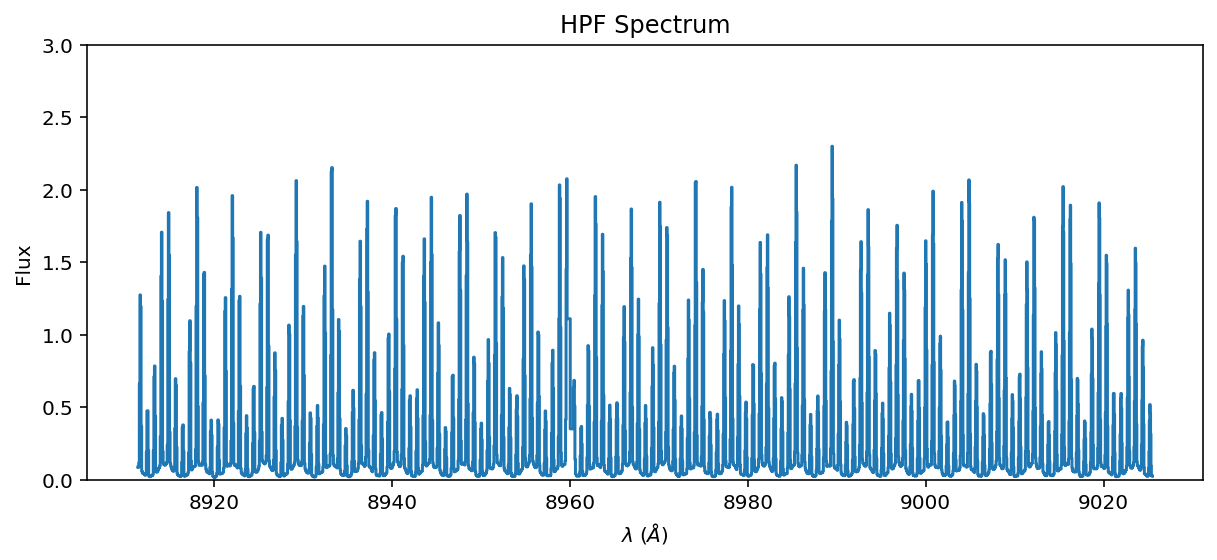

In [6]:
file = '/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T082120_v1.0_0005.spectra.fits'
#file = '/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20210101T014242_v1.0_0022.spectra.fits'
spec = HPFSpectrum(file=file, order=7)

spec = spec.lfc

spec = spec.trim_edges((10, 2040)).remove_nans().deblaze()
scalar = np.percentile(spec.flux, 90)
spec = spec.divide(scalar, handle_meta='ff')

spec_orig = spec._copy()

#mask = spec.flux.value > 0.03
#spec = spec.apply_boolean_mask(mask)

spec.plot(ylo=0, yhi=3)

In [5]:
spec.meta['header']['OBJECT']

'LFC Cal'

In [6]:
spectrum = spec

In [7]:
spectrum.bin_edges

<Quantity [8911.41203027, 8911.47747527, 8911.54291608, ..., 9025.41340109,
           9025.45993738, 9025.50646865] Angstrom>

In [8]:
guess_sigma = 0.01
guess_gamma = 0.07

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [9]:
from scipy.signal import find_peaks

In [10]:
peaks = find_peaks(spec_orig.flux.value, distance=10, prominence=0.01)[0]

In [11]:
peak_coords = spec_orig.wavelength.value[peaks]

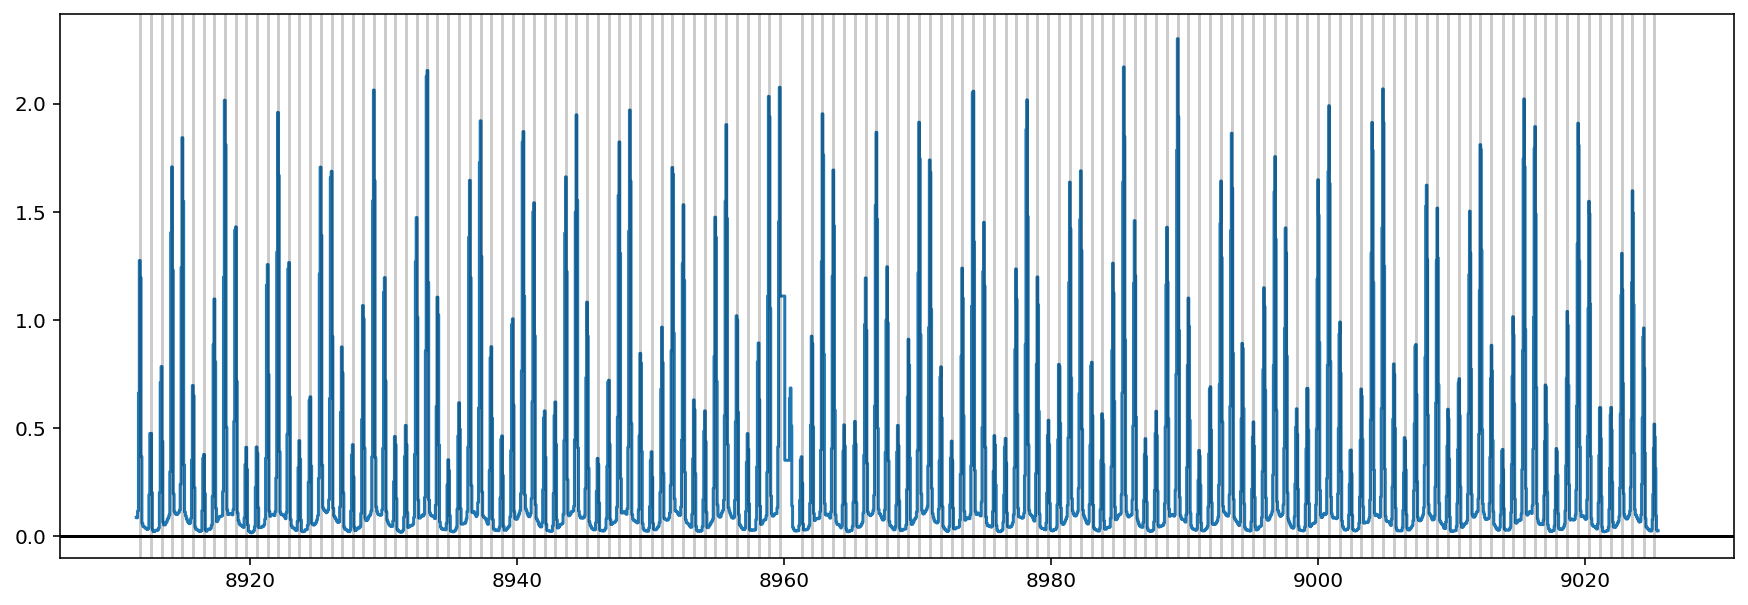

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.step(spectrum.wavelength, spectrum.flux, where='mid')

for xv in peak_coords:
    ax.axvline(xv, linestyle='solid', alpha=0.2, color='k')
    
ax.axhline(0.0, color='k');

We have detected all the spectral lines

In [13]:
wl_lo = spectrum.wavelength.min().value-30.0
wl_hi = spectrum.wavelength.max().value+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

## Model the lines with blasé

In [14]:
from blase.emulator import SparseLogEmissionEmulator

In [15]:
from collections import OrderedDict

In [16]:
peak_coords = torch.from_numpy(peak_coords)
guess_amps = 0.2*torch.ones_like(peak_coords)

In [17]:
n_lines = len(peak_coords)

In [18]:
state_dict = OrderedDict({'lam_centers':peak_coords,
                  'amplitudes':torch.log(guess_amps), 
                  'sigma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_sigma), n_lines)), 
                  'gamma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_gamma), n_lines)),
                  'a_coeff':torch.tensor(1.0), 
                  'b_coeff':torch.tensor(0.0),
                  'c_coeff':torch.tensor(0.0), 
                  'radial_velocity':torch.tensor(0.0)})

### Guess and check

In [19]:
emission_model = SparseLogEmissionEmulator(wavelength_grid, 
                                     init_state_dict=state_dict, wing_cut_pixels=100, device=device)
emission_model.to(device)

Initializing a sparse model with 141 spectral lines


SparseLogEmissionEmulator()

In [ ]:
emiss

In [20]:
import math

In [21]:
math.sqrt(math.pi)

1.7724538509055159

In [22]:
with torch.no_grad():
    emission_spec = emission_model.forward()

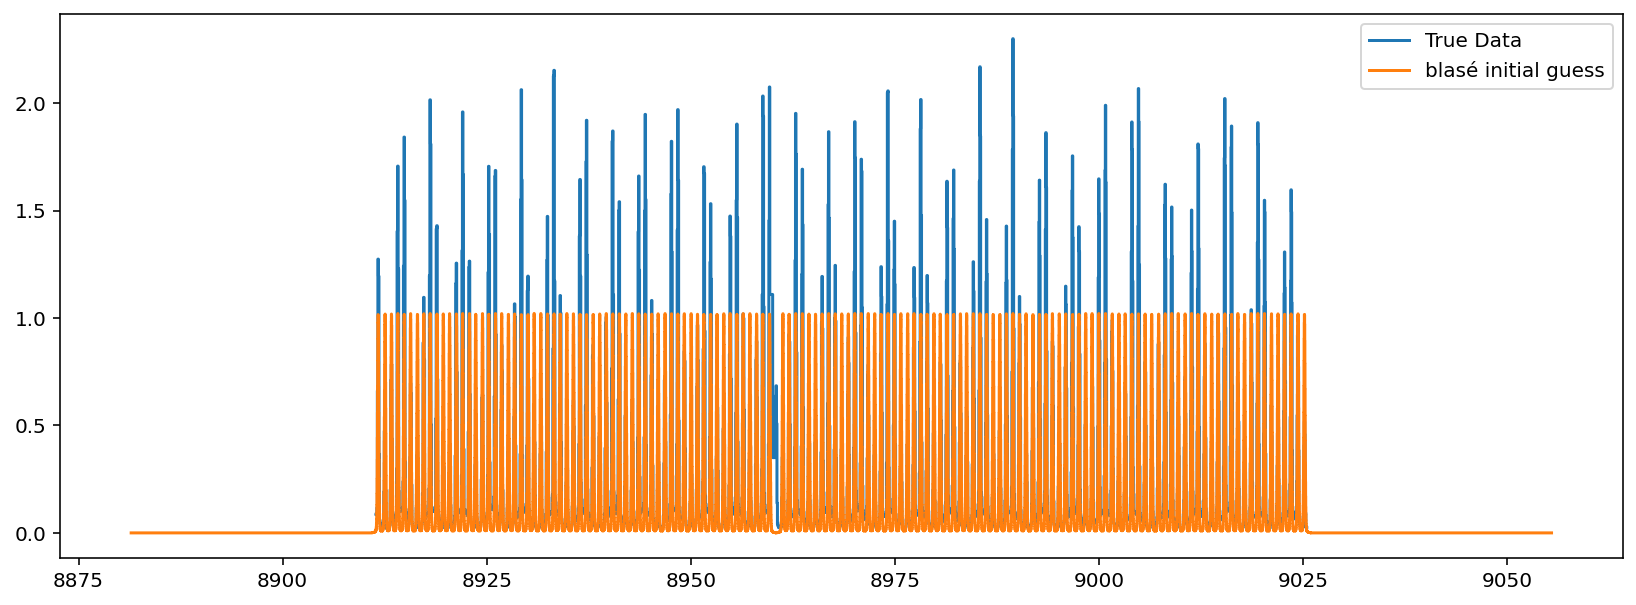

In [23]:
plt.figure(figsize=(14, 5))
plt.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data')
plt.step(wavelength_grid, emission_spec, where='mid', label='blasé initial guess')
#plt.xlim(10820, 10850)
plt.legend();

#### Instrumental model

In [24]:
instrumental_model = InstrumentalModel(spectrum.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [25]:
#instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [26]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [27]:
data_target = torch.tensor(
    spectrum.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    spectrum.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [28]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [29]:
# Fix all stellar parameters except amplitude and RV
emission_model.amplitudes.requires_grad = True
emission_model.radial_velocity.requires_grad = False
emission_model.lam_centers.requires_grad = True
emission_model.sigma_widths.requires_grad = True
emission_model.gamma_widths.requires_grad = True
emission_model.a_coeff.requires_grad = False
emission_model.b_coeff.requires_grad = False
emission_model.c_coeff.requires_grad = False

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = False
instrumental_model.linear_model.weight.requires_grad = False
instrumental_model.linear_model.bias.requires_grad = False

In [30]:
const_term = torch.tensor(0.01, requires_grad=True, device=device)

In [31]:
nk = 31
kernel = torch.zeros(nk, requires_grad=True, dtype=torch.double, device=device)

In [32]:
def modulation_func(lengthscale, modamp1, modamp2, wl):
    '''Never fit phase'''
    sinterm = modamp1 * torch.sin(2.0 * math.pi * wl/lengthscale)
    costerm = modamp2 * torch.cos(2.0 * math.pi * wl/lengthscale)
    return sinterm + costerm

In [33]:
modulation_params = torch.tensor([7.7, 0.1, 0.0], requires_grad=True, dtype=torch.double)

In [34]:
tuning_params = list(filter(lambda p: p.requires_grad, emission_model.parameters()))\
                + [const_term] \
                + [kernel] \
                + [modulation_params]

In [35]:
tuning_params

[Parameter containing:
 tensor([8911.7065, 8912.5562, 8913.3393, 8914.1211, 8914.9018, 8915.6812,
         8916.5242, 8917.3011, 8918.0767, 8918.9157, 8919.6888, 8920.4606,
         8921.2954, 8922.0647, 8922.8967, 8923.6634, 8924.4925, 8925.2566,
         8926.0830, 8926.8444, 8927.6680, 8928.4268, 8929.2475, 8930.0667,
         8930.8215, 8931.6378, 8932.4527, 8933.2660, 8934.0154, 8934.8259,
         8935.6348, 8936.4423, 8937.2482, 8938.0526, 8938.8556, 8939.6570,
         8940.4568, 8941.2552, 8942.0521, 8942.8474, 8943.6412, 8944.4335,
         8945.2242, 8946.0134, 8946.8616, 8947.6476, 8948.4321, 8949.2151,
         8950.0565, 8950.8363, 8951.6145, 8952.4508, 8953.2258, 8954.0587,
         8954.8304, 8955.6598, 8956.4284, 8957.2543, 8958.0784, 8958.8420,
         8959.6626, 8961.2984, 8962.0554, 8962.8689, 8963.6806, 8964.4904,
         8965.2984, 8966.1046, 8966.9090, 8967.7115, 8968.5122, 8969.3110,
         8970.1081, 8970.9033, 8971.7532, 8972.5446, 8973.3342, 8974.1781,
  

In [36]:
optimizer = optim.Adam(tuning_params,0.05,amsgrad=True)         

In [37]:
n_epochs = 500
losses = []

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [38]:
#per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

make an adhoc kernel to convolve with

In [39]:
#with torch.no_grad():
#    lhs = emission_model.forward().unsqueeze(0).unsqueeze(1)
#    rhs = kernel#.unsqueeze(0).unsqueeze(1)
#    out = torch.nn.functional.conv1d(lhs, rhs, padding='same').squeeze()

In [40]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emission_model.train()
    instrumental_model.train()
    
    flux = emission_model.forward()
    lengthscale, modamp1, modamp2 = modulation_params
    modulated_flux = modulation_func(lengthscale, modamp1, modamp2, emission_model.wl_native) + flux
    kernel_term = torch.exp(kernel.unsqueeze(0).unsqueeze(1))
    warped_flux = torch.nn.functional.conv1d(modulated_flux.unsqueeze(0).unsqueeze(1), 
                                             kernel_term/kernel_term.sum(), padding='same').squeeze()
    detector_flux = instrumental_model.resample_to_data(warped_flux)+const_term
    
    loss = loss_fn(detector_flux, data_target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00100497: 100%|██████████████| 500/500 [00:26<00:00, 18.99it/s]


In [41]:
lambda_kernel = torch.cumsum(torch.diff(emission_model.wl_native[5848:5848+nk+1]), 0)
lambda_kernel = lambda_kernel - torch.median(lambda_kernel)
lambda_kernel

tensor([-0.2244, -0.2094, -0.1945, -0.1795, -0.1645, -0.1496, -0.1346, -0.1197,
        -0.1047, -0.0897, -0.0748, -0.0598, -0.0449, -0.0299, -0.0150,  0.0000,
         0.0150,  0.0299,  0.0449,  0.0598,  0.0748,  0.0897,  0.1047,  0.1197,
         0.1346,  0.1496,  0.1645,  0.1795,  0.1945,  0.2094,  0.2244],
       dtype=torch.float64)

Text(0.5, 0, '$\\Delta \\lambda~(\\AA)$')

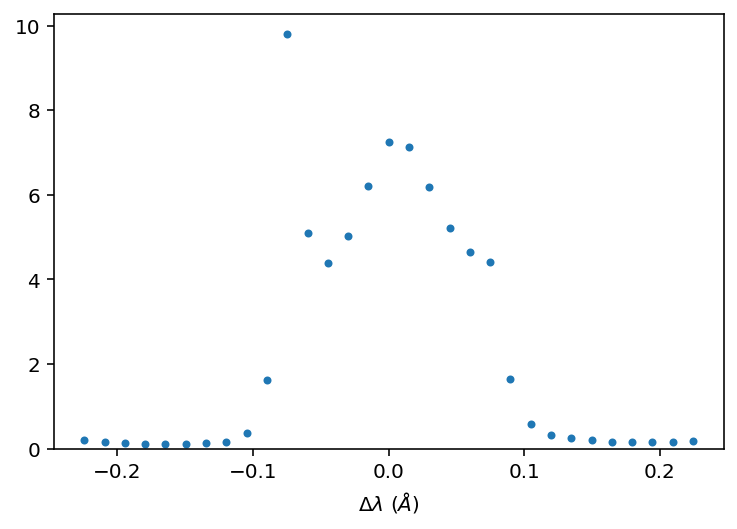

In [42]:
with torch.no_grad():
    plt.plot(lambda_kernel, torch.exp(kernel), '.')
plt.ylim(0)
plt.xlabel('$\Delta \lambda~(\AA)$')

### Spot check the transfer-learned joint model

In [43]:
residual = spectrum.flux - detector_flux.detach().cpu().numpy()

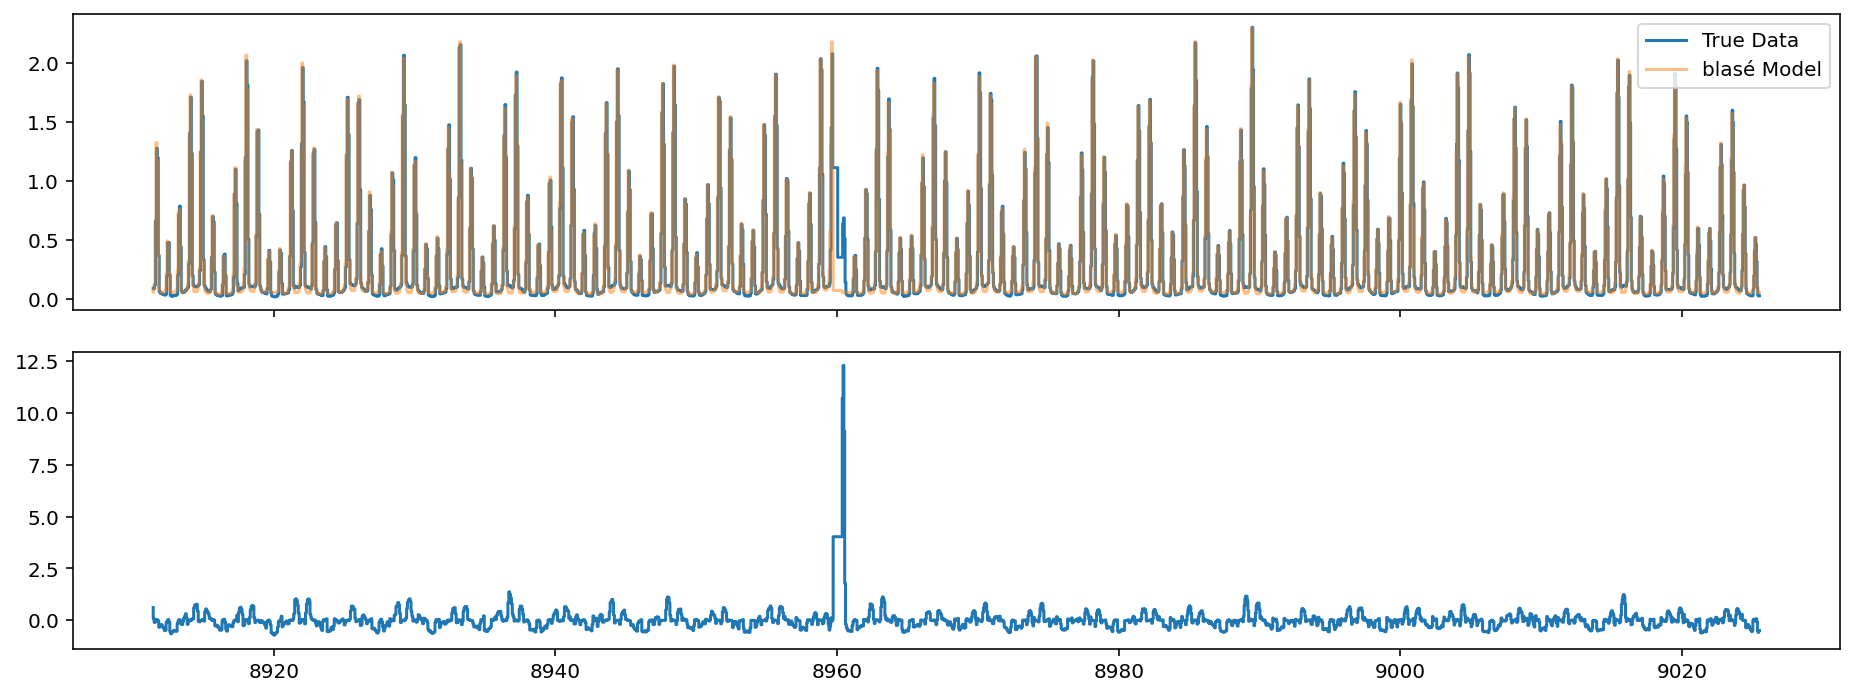

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5);
ax2.step(spectrum.wavelength,residual/detector_flux.detach().cpu().numpy())
ax1.legend();

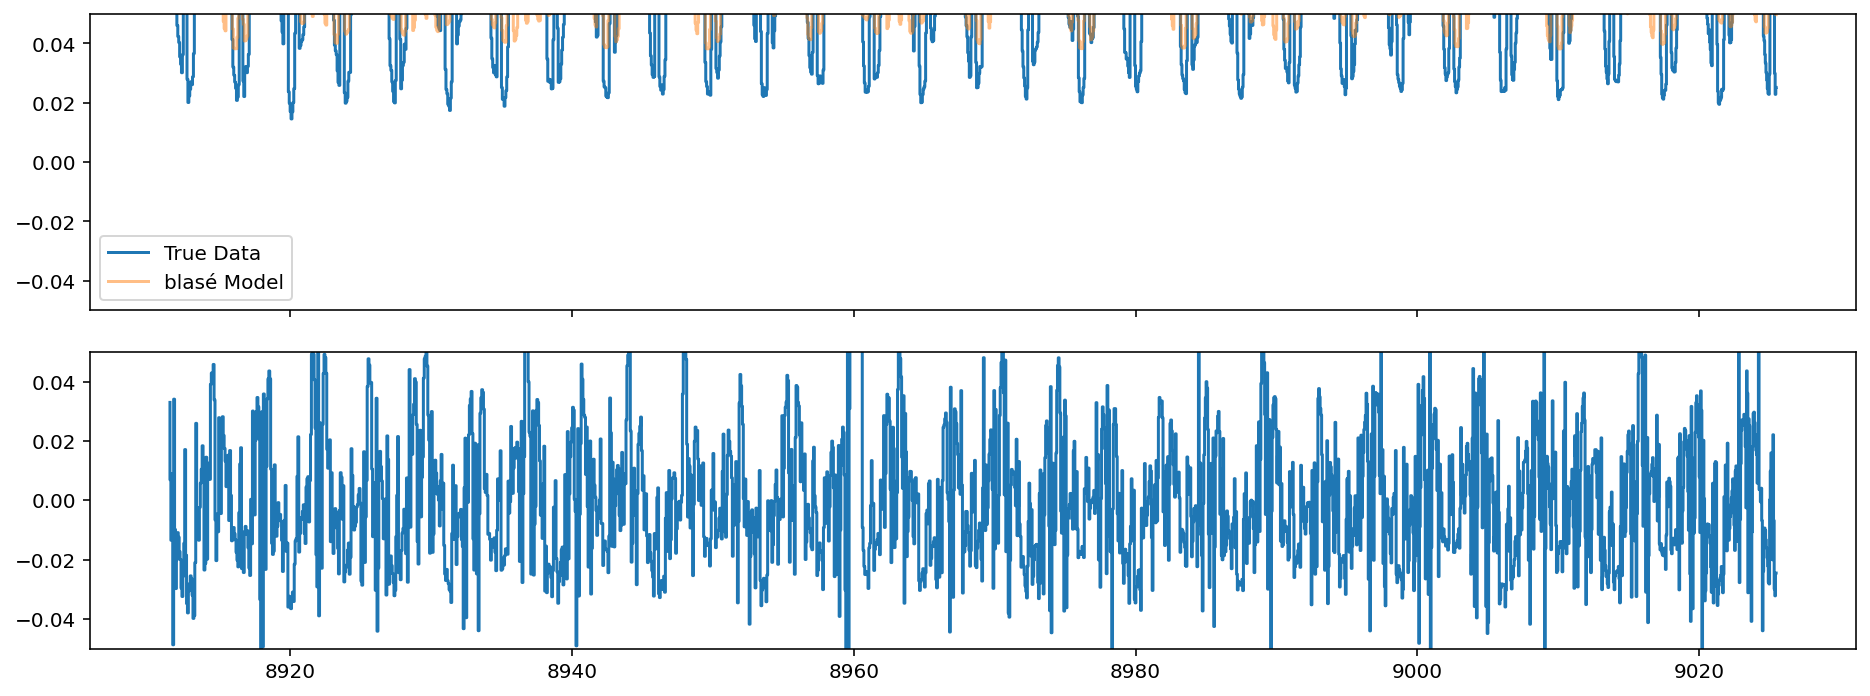

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5);
ax2.step(spectrum.wavelength,residual)
ax1.set_ylim(-0.05, 0.05)
ax2.set_ylim(-0.05, 0.05)
ax1.legend();

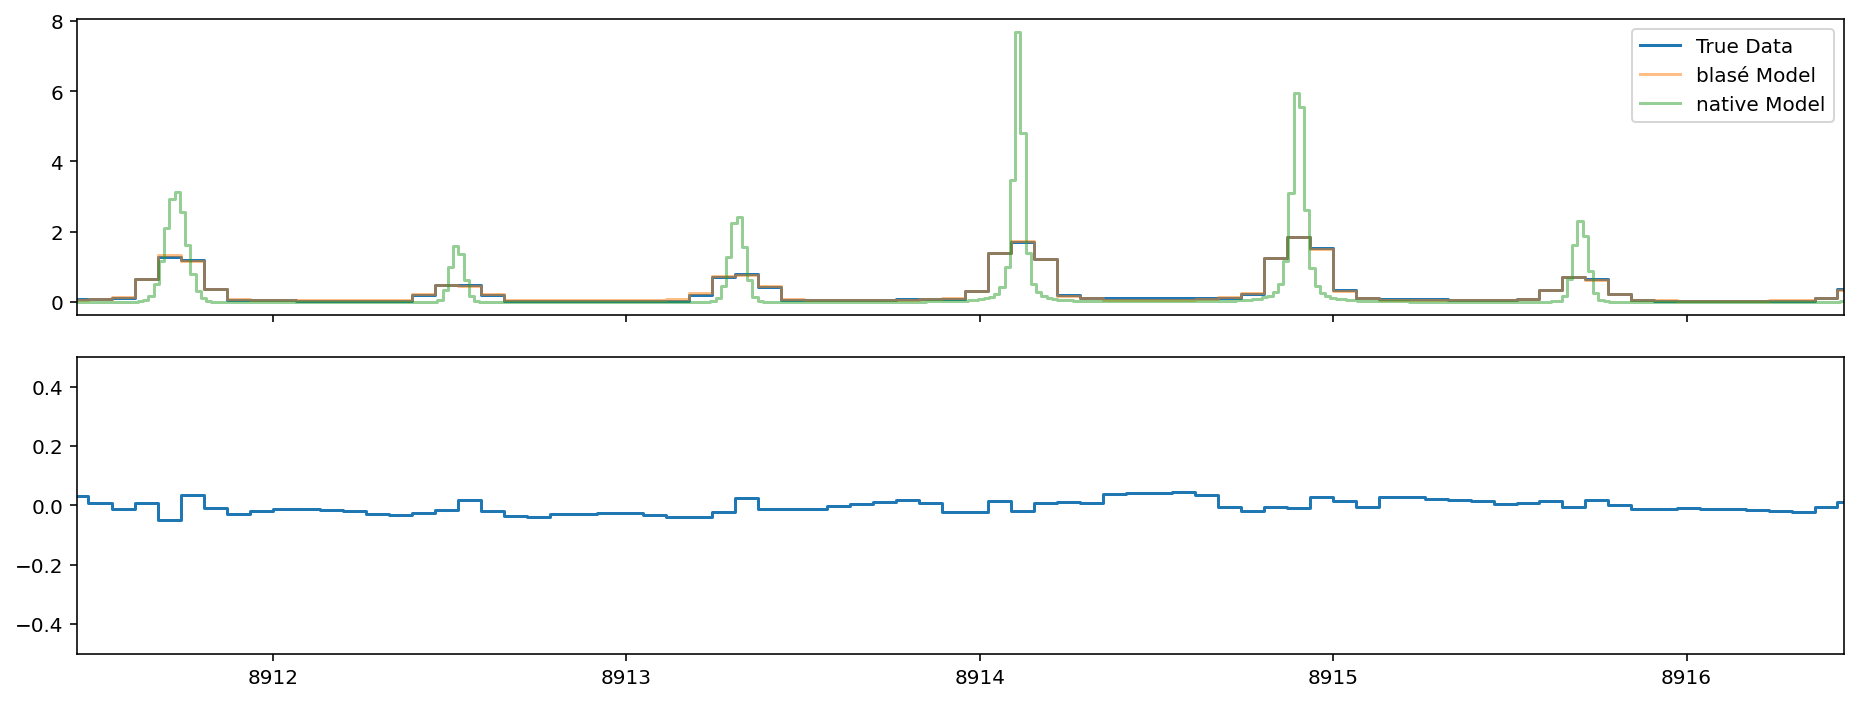

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5, where='mid');
ax2.step(spectrum.wavelength,residual, where='mid')

with torch.no_grad():
    ax1.step(emission_model.wl_native, emission_model.forward(), label='native Model', alpha=0.5, where='mid');

ax1.set_xlim(spectrum.wavelength.min().value, spectrum.wavelength.min().value+5)
ax2.set_xlim(spectrum.wavelength.min().value, spectrum.wavelength.min().value+5)
ax2.set_ylim(-0.5, 0.5)
ax1.legend();

Hooray! We match the data pretty well!

In [47]:
np.std(residual)

<Quantity 0.03170096>

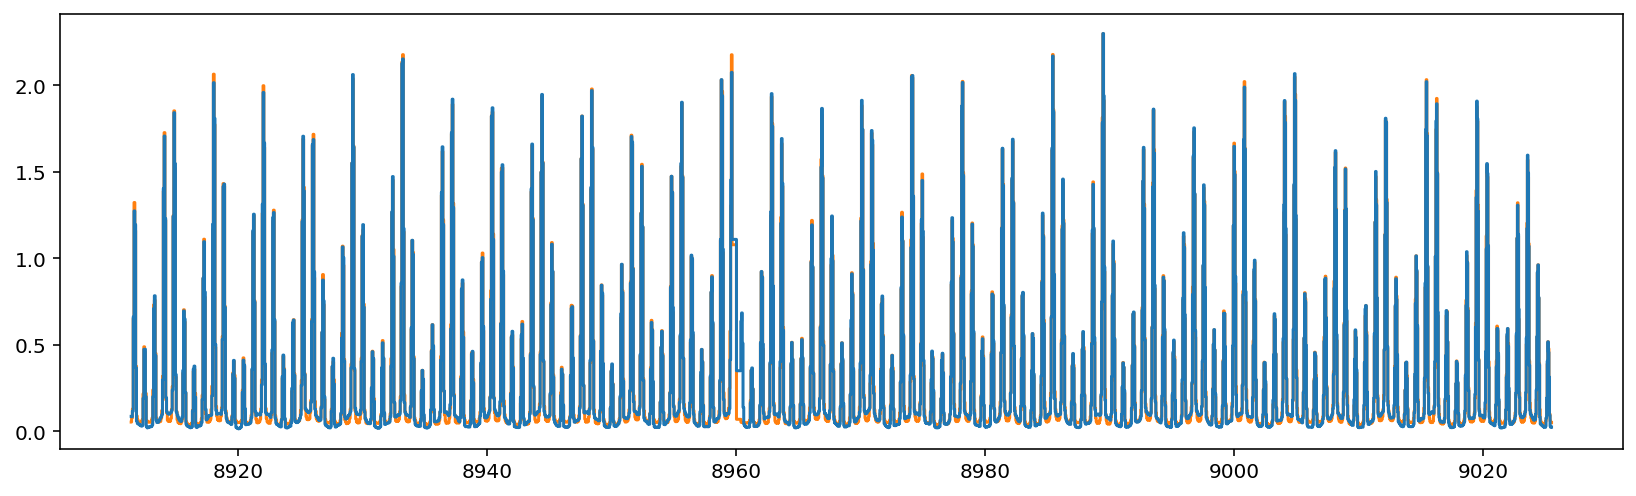

In [48]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid', zorder=11);
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
#ax.set_xlim(10690, 10710)

Looks great, albeit not perfect-- we are resampling spectra, which should have an effect here...

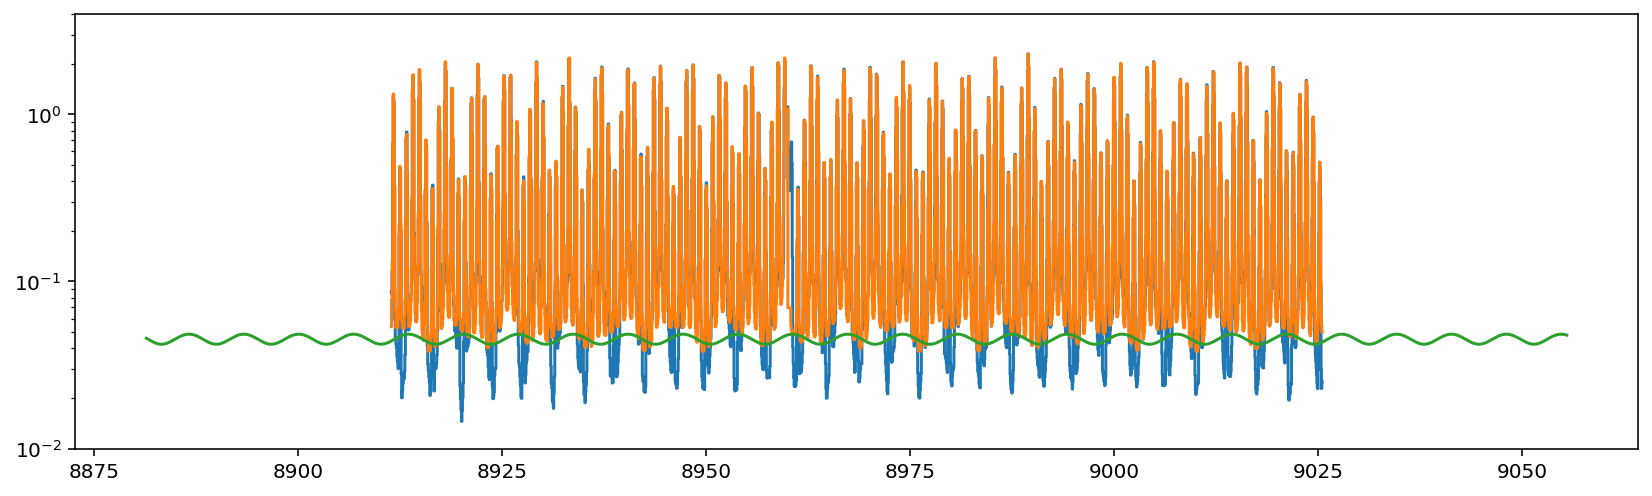

In [49]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
#ax.set_xlim(spectrum.wavelength.min().value, spectrum.wavelength.min().value+20)
ax.set_ylim(1e-2, 4)
with torch.no_grad():
    lengthscale, modamp1, modamp2 = modulation_params
    plt.plot(emission_model.wl_native, 
             const_term + modulation_func(lengthscale, modamp1, modamp2, emission_model.wl_native))

ax.plot()
plt.yscale('log')

A ha! Our Voigt profile drops off too quickly--- we need heavier tails!  Something is wrong in our prescription...

### Inspect the individual stellar and telluric components

In [50]:
with torch.no_grad():
    delta_lam_center = torch.diff(emission_model.lam_centers.detach())

(0.6, 1.0)

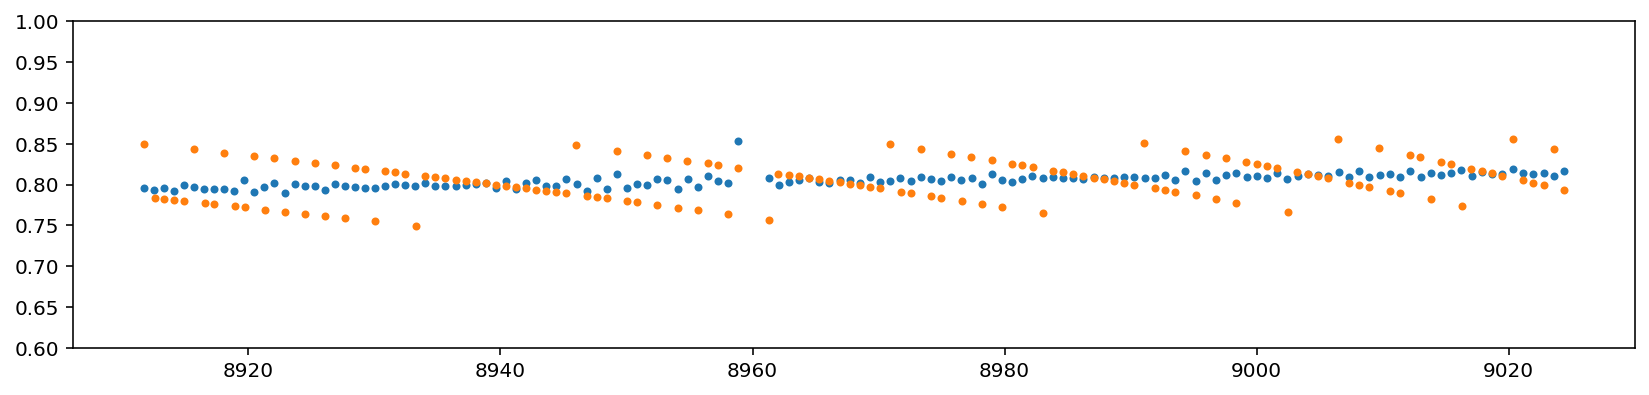

In [53]:
fig, ax = plt.subplots(figsize=(14,3))
plt.plot(emission_model.lam_centers.detach()[0:-1], delta_lam_center, '.')

plt.plot(peak_coords[0:-1], torch.diff(peak_coords), '.')

plt.ylim(0.6, 1)

In [53]:
retrieved_sigmas = torch.exp(emission_model.sigma_widths.detach()).numpy()
retrieved_gammas = torch.exp(emission_model.gamma_widths.detach()).numpy()
retrieved_amps = torch.exp(emission_model.amplitudes.detach()).numpy()

In [51]:
guess_sigma

0.01

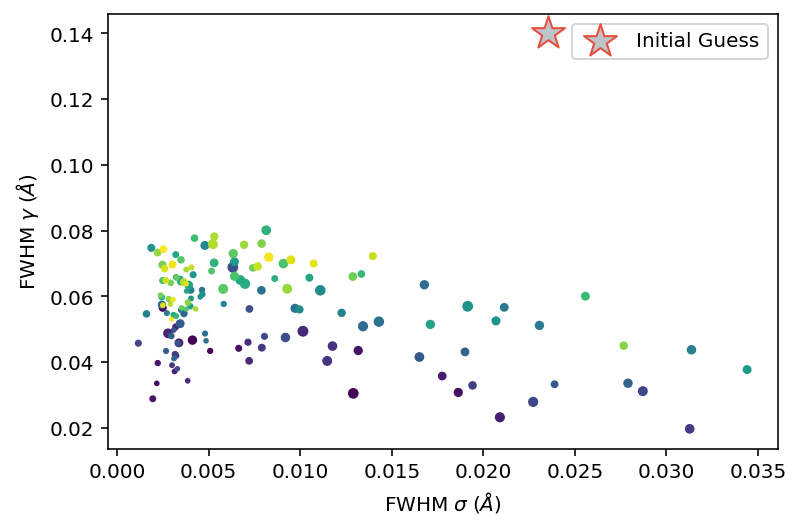

In [52]:
plt.scatter(2.355*retrieved_sigmas, 2*retrieved_gammas, s=retrieved_amps*40, c=peak_coords.numpy())

plt.xlabel('FWHM $\sigma \; (\AA)$')
plt.ylabel('FWHM $\gamma \; (\AA)$')
plt.scatter([2.355*guess_sigma], [2*guess_gamma], marker='*', s=300, color='#bdc3c7', ec='#e74c3c', label='Initial Guess')
plt.legend();

## Insights

Weird! We find an incompatible locus of posterior parameters--- why?

We have nearly-degenerate families of solutions: you can turn up $\sigma$ and down $\gamma$ (or vice versa) and get about the same answer.  We could/should have instead fit for FWHM and then a shape parameter $(\in 0-1)$.  With that parameterization we would get an exact FWHM constraint, but only a weak constraint on the shape parameter. We may want to do that moving forward!


Even still, it might seem odd that a noise-free spectrum doesn't converge to the exact input, after all there is zero noise added to the input.  Here are some reasons why we still don't get the "right answer":


- We chose Voigt wings that are weak and only manifest near zero flux, where other factors may dominate.  
- Pixel resampling could matter at this level
- The approximations in our implementaiton of the ExoJAX HJERT may be inexact
- The wingcut could matter
- A bug somewhere
- Initial guess matters